# Worksheet 17

Name:  Afiq Amjad bin Khairir
UID: U41760804

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

1. Create a binary system where a like is represented by 1 and a dislike is represented by 0.

b) Describe 3 challenges of building a recommender system

1. Scaling
2. Cold Start
3. Scarce data

c) Why is SVD not an option for collaborative filtering?

This is because the data for user-to-item matrices are scarce, therefore if SVD is used then it will perform poorly.

d) Use the code below to train a recommender system on a dataset of amazon movies

/Users/afiqk/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Kaggle RMSE =  1.426503101954434


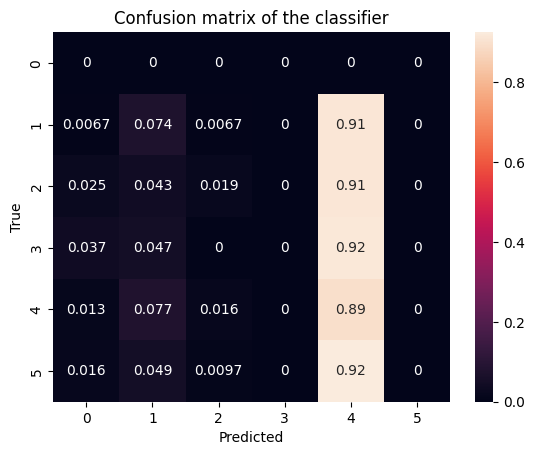

In [4]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()
X_test_merged = X_test_processed.merge(rec, on=['UserId_fact', 'ProductId_fact'], how='left')
average_score = init_df['Score'].mean()
X_test_merged['prediction'] = X_test_merged['prediction'].fillna(average_score)

print("Kaggle RMSE = ", mean_squared_error(Y_test, X_test_merged['prediction'],  squared=False))

cm = confusion_matrix(Y_test, X_test_merged['prediction'].astype(int), normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()